In [1]:
import time
import pandas as pd
import os
from pyarrow import csv, parquet
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [2]:
path_clean = "data/clean/TRTH/equities/US"
file_csv_gz = os.path.join(path_clean, 'AAPL.OQ.csv.gz')
file_parquet = os.path.join(path_clean, 'AAPL.OQ.parquet')
file_hdf = os.path.join(path_clean, 'AAPL.OQ.h5')

# CSVGZ TO PANDAS
t0 = time.time()
allevents = pd.read_csv(file_csv_gz)
t1 = time.time()
read_csvgz_time = t1 - t0

# CSVGZ TO PYARROW TO PANDAS
t0 = time.time()
table_1 = csv.read_csv(file_csv_gz)
df = table_1.to_pandas()
t1 = time.time()
read_csvgz_to_pyarrow_time = t1 - t0

# PARQUET TO PANDAS
t0 = time.time()
df = pd.read_parquet(file_parquet)
t1 = time.time()
read_parquet_time = t1 - t0

# PARQUET TO PYARROW TO PANDAS
t0 = time.time()
table_2 = parquet.read_table(file_parquet)
df = table_2.to_pandas()
t1 = time.time()
read_parquet_to_pyarrow_time = t1 - t0

# HDF5 TO PANDAS
t0 = time.time()
df = pd.read_hdf(file_hdf)
t1 = time.time()
read_hdf5_time = t1 - t0

In [3]:
# Feature engineering
t0 = time.time()
SimData = pd.DataFrame(index=allevents.index)
SimData['total-traded'] = allevents['trade_price'] * allevents['trade_volume']
SimData['bid-ask-spread'] = allevents['bid-price'] - allevents['ask-price']
SimData['imbalance'] = allevents['bid-volume'].rolling(5).sum() - allevents['ask-volume'].rolling(5).sum()
SimData['change'] = (allevents.trade_price - allevents.trade_price.shift(-30) > 0).astype('int')
SimData.dropna(how='any', inplace=True)

array = SimData.values
X = array[:, 0:3]
y = array[:, 3]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=None)

# Use a Decision Tree Classifier for prediction
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
t1 = time.time()
prediction_time = t1 - t0

Accuracy of the prediction : 
0.6859040254719126
Confusion matrix, without normalization
[[128465  47733]
 [ 55848  97729]]
Normalized confusion matrix
[[0.72909454 0.27090546]
 [0.3636482  0.6363518 ]]
Classification report : 
              precision    recall  f1-score   support

         0.0       0.70      0.73      0.71    176198
         1.0       0.67      0.64      0.65    153577

    accuracy                           0.69    329775
   macro avg       0.68      0.68      0.68    329775
weighted avg       0.69      0.69      0.69    329775



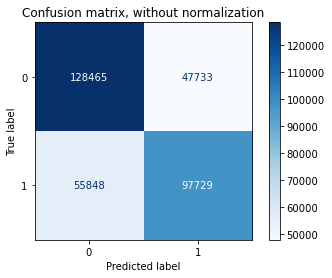

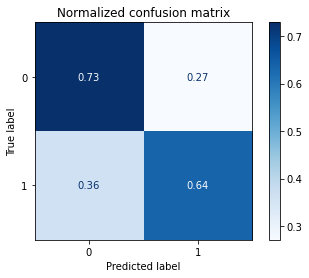

Reading time, csv.gz... 1.4513452053070068 s
Reading time, csv.gz via pyarrow... 0.9410240650177002 s
Reading time, parquet... 0.30204319953918457 s
Reading time, parquet via pyarrow... 0.10793113708496094 s
Reading time, hdf5... 0.6892409324645996 s
Prediction time... 11.954690933227539 s


In [4]:
# Evaluates the predictions
# Accuracy
print("Accuracy of the prediction : \n" + str(accuracy_score(Y_validation, predictions)))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_validation, Y_validation,
                                 display_labels=['0', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

# Classification report
print("Classification report : ")
print(classification_report(Y_validation, predictions))
plt.show()

print('Reading time, csv.gz...', read_csvgz_time, 's')
print('Reading time, csv.gz via pyarrow...', read_csvgz_to_pyarrow_time, 's')
print('Reading time, parquet...', read_parquet_time, 's')
print('Reading time, parquet via pyarrow...', read_parquet_to_pyarrow_time, 's')
print('Reading time, hdf5...', read_hdf5_time, 's')
print('Prediction time...', prediction_time, 's')